## Annotation Types
* This is a common format that we created to make the following easier:
    1. Format conversion
    2. ETL Pipelines
    3. Training Models

------
* This is something we are actively developing. But at this moment we currently support:
1. Core interfaces
2. labelbox export format <-> annotation types
3. labelbox prediction import format <-> annotation types

(This is not currently compatible with tiled imagery.)


### Core Interfaces:

The interfaces are designed to represent data for machine learning models.
This means that you can use them without using labelbox or having references to labelbox objects. 
Functions for connecting annotations to labelbox are provided.


These are usually built from the ground up:


In [11]:
# Import basic data
from labelbox.data.annotation_types import (
    LabelCollection,
    Label,
    RasterData,
    TextData,
    VideoData,
    ObjectAnnotation,
    ClassificationAnnotation,    
    Polygon,
    Rectangle,
    Line,
    Mask,
    Point,
    Checklist,
    Radio,
    Text,
    ClassificationAnswer
)

import requests
from PIL import Image
from io import BytesIO
import numpy as np
from shapely.ops import transform
from shapely.affinity import affine_transform

# Data 
* There are three classes to represent data
    * TextData
    * VideoData
    * RasterData
* The data objects can be constructed from various representations
    - remote (url, uri)
    - disk ( file path)
    - compressed (image bytes)
    - memory ( numpy array, 
* Then the access pattern is consistent regardless of the format used to construct the object


### Raster

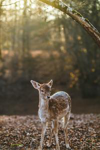

In [12]:
# Data can be instantiated with any of the following
image = RasterData(im_bytes = b'bytes')
image = RasterData(arr = np.zeros((10,10)).astype(np.uint8))
image = RasterData(file_path = '/tmp/img.jpg')
image_url = "https://picsum.photos/id/1003/200/300"
image = RasterData(url = image_url)
# All of these can access the numpy representation the same way:
np_data = image.data


# Why is this useful?
# Maybe you just have some local images you are running predictions on.
# Instantiate an array or a file path



"""
One valid object representation that breaks this pattern is:
    data = RasterData(uid = "some label cuid")

Support for this needs to be implemented for all data!!!!!!!


"""
# We can see the numpy version of our url

im = Image.fromarray(np_data)
im.resize((im.size[0]//2, im.size[1]//2))

### Text

In [13]:
# Text has the same access pattern as imagery.
text = TextData(file_path = "/tmp/some local file.txt")
text = TextData(text = " some text content...")
text = TextData(url = "https://filesamples.com/samples/document/txt/sample3.txt")

print(text.data[:100])

Quod equidem non reprehendo;
Lorem ipsum dolor sit amet, consectetur adipiscing elit. Quibus natura 


### Video

In [14]:
video_url = "http://commondatastorage.googleapis.com/gtv-videos-bucket/sample/ForBiggerMeltdowns.mp4"

video = VideoData(file_path = "some video path.mp4")
video = VideoData(frames = { 1: np.zeros((32, 32, 3), dtype = np.uint8)})
video = VideoData(url=video_url)


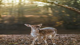

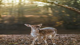

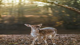

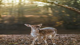

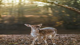

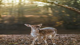

In [15]:
import IPython
for idx, frame in video.frame_generator():
    if idx % 50 == 0:
        video_im = Image.fromarray(frame)
        w,h = video_im.size
        IPython.display.display( im.resize((w//16, h//16) ))        
    if idx > 250:
        break



### Advanced

#### Adding data row information
* This is not required ( and can be added at a later time but you can add data row information to your data)


In [16]:
td = TextData(text = "some text", uid = "ckrey6o07000008l50uk2gcr3", external_id = "my_text_data_row")
rd = RasterData(url = image_url, uid = "ckrey7te2000108l5hl8564dr", external_id = "my_raster_data_row")
vd = VideoData(url = video_url, uid = "ckrey7xef000208l57hwfgi3v", external_id = "my_video_data_row")

# TODO: Add apply to all function for label so users don't need to set this themselves

In [17]:
# Edge cases:
# If your remote data isn't stored as a signed url or publicly accessible there is a workaround.
# Define a fetching function

# Eg. the following if you need headers:
#image.fetch_remote = lambda self: requests.get(self.url, headers = {...}).content
# Or even accessing data from s3 if you did RasterData(url = "s3://some s3 uri")


# Annotations

* Create an annotation by providing the following:
1. Value
    - Must be either a Geometry, TextEntity, or Classification
    - This is the same as a top level tool in labelbox
2. name or schema_id
    - This is the id that corresponds to a particular class or just simply the class name
    - If uploading to labelbox this must match a field in an ontology.
3. (Optional) Classifications 
    - List of ClassificationAnnotations. This self referencing field enables infinite nesting of classifications.
    - Be careful with how you use the tool. Labelbox does not support nesting classifications
    - E.g. you can have tool.classifications but not tool.classifications[0].classifications
        

### ObjectAnnotation

In [18]:
# Given some polygon:
xy_poly = [[60.215, 160.706], [67.135, 176.513], [76.36, 180.136], [76.69, 222.287], [81.632, 245.668], [77.678, 291.442],
 [72.077, 300], [86.904, 300], [94.482, 243.692], [103.378, 243.363], [100.413, 269.378], [90.199, 289.795],
 [95.141, 296.381], [103.708, 292.43], [107.662, 271.683], [110.957, 300], [121.171, 299.675], [117.217, 243.692], [127.761, 236.118],
 [132.703, 298.028], [142.258, 297.369], [136.657, 249.949], [145.553, 207.797], [137.975, 185.075],
 [120.182, 180.465], [105.026, 189.356], [111.616, 161.694], [92.835, 155.767], [72.077, 160.048]]


annotation = ObjectAnnotation(
            value = Polygon(points = [Point(x = x, y = y) for x,y in xy_poly]),
            name = "deer"
        )

In [19]:
"""
# 2. All Geometry annotations have the same set of useful functions:
- raster()
- shapely
- geometry

"""
# Geojson
print(annotation.value.geometry)

{"coordinates": [[[60.215, 160.706], [67.135, 176.513], [76.36, 180.136], [76.69, 222.287], [81.632, 245.668], [77.678, 291.442], [72.077, 300.0], [86.904, 300.0], [94.482, 243.692], [103.378, 243.363], [100.413, 269.378], [90.199, 289.795], [95.141, 296.381], [103.708, 292.43], [107.662, 271.683], [110.957, 300.0], [121.171, 299.675], [117.217, 243.692], [127.761, 236.118], [132.703, 298.028], [142.258, 297.369], [136.657, 249.949], [145.553, 207.797], [137.975, 185.075], [120.182, 180.465], [105.026, 189.356], [111.616, 161.694], [92.835, 155.767], [72.077, 160.048], [60.215, 160.706]]], "type": "Polygon"}


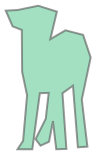

In [20]:
def flip_y_axis(poly, height):
    return affine_transform(poly,[1, 0, 0, -1, 0, height])


flip_y_axis(annotation.value.shapely, im.size[1])


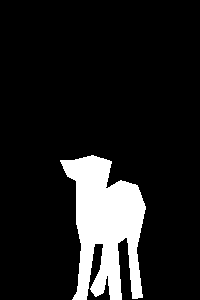

In [21]:
color = 255
np_mask = annotation.value.raster(height = im.size[1], width = im.size[0], color = color)
Image.fromarray(np_mask)

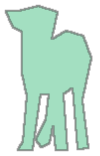

In [22]:
# Another cool thing is if you have a mask object you can convert it back to a polygon:
# Multiple Mask annotations can share a single RasterData reference.
# The color is used to indicate whether or not those objects are the same class.
mask_annotation = Mask(
    mask = RasterData(arr = np_mask),
    color = color 
)

flip_y_axis(mask_annotation.shapely, im.size[1])




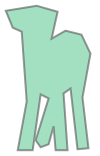

In [23]:
# It is the same polygon but with extra vertices. We can also simplify it:
flip_y_axis(mask_annotation.shapely, im.size[1]).simplify(4)

In [24]:
# In addition to masks and polygons we also support:

point = Point(x = 5, y = 5)

# Start is the top left coordinate
# End is the bottom right coordinate
rectangle = Rectangle(start = Point(x = 0, y = 5), end = Point(x = 5, y = 10))

# Polyline, (can have more than two points)
line = Line(points = [Point(x = 0, y = 0), Point(x = 1, y = 1), Point(x = 2, y = 1)])


### Classification Annotation

In [ ]:
text_annotation = ClassificationAnnotation(
    name = "my text class", 
    value = Text(answer = "some text answer")                               
)

# It is also valid to provide a schema_id instead of the name

text_annotation = ClassificationAnnotation(
    schema_id = "my text class", 
    value = Text(answer = "some text answer")                               
)

In [ ]:
# Classification Answers can either be defined by a schema id or just the value
# If uploading to labelbox the schema_id must be value or the value must match a classifiation name in the ontology.
radio_annotation = ClassificationAnnotation(
    name = "is dog",
    value = Radio(answer = ClassificationAnswer(name = "dog")) 
)


radio_annotation = ClassificationAnnotation(
    schema_id = "ckresqdg7000001jnb70v4zcc",
    value = Radio(answer = ClassificationAnswer(schema_id = "ckrdy06ia000007ky94h04qlj")) 
)

In [ ]:
#Check list supports a list of AnnotationAnswers
checklist_annotation = ClassificationAnnotation(
    schema_id = "ckrestd5g000101jnhudjf29a",
    value = Checklist(answer = [ClassificationAnswer(schema_id = "ckrdy06ia000007ky94h04qlj")])
)
                                
checklist_annotation = ClassificationAnnotation(
    name = "weather",
    value = Checklist(answer = [ClassificationAnswer(name = "cloudy")]) 
)

### Nested Classifications

* All classifications can be nested
# TODO: Do we want to not support this since it doesn't align with labelbox?




In [ ]:

annotation = ObjectAnnotation(
            value = Polygon(points = [Point(x = x, y = y) for x,y in xy_poly]),
            name = "deer",
            classifications = [
                checklist_annotation, radio_annotation
            ]
)

# Labels
* Labels connect a list of annotations to data such as images, text, and video.
* Labels have a convenient set of functions for dealing with that collection of data

In [25]:
# Let's make a label:
label = Label(
    data = RasterData(url = image_url),
    annotations = [
        ObjectAnnotation(
            value = Polygon(points = [Point(x = x, y = y) for x,y in xy_poly]),
            name = "deer"
        ),
        ObjectAnnotation(
            name = "deer_eyes",
            value = Mask(mask = RasterData(arr = np_mask), color = color)
        )
    ]
)

### Interacting with labelbox:
* For this label to be compatible with labelbox we need the following:
    - all named features must have schema_ids
    - all data must have urls
        - masks
        - images
        - videos
        - text
    

In [26]:
from labelbox import Client
client = Client()


### Uploading Urls
* It doesn't matter how urls are set
* Manually setting urls or use helper functions are both valid for working with labelbox

In [27]:
# Manually set just by adding a value:
image = RasterData(arr = np_data)
image.url = "http://myurl"

* Use helper function:
    - Upload image urls : `Label.add_url_to_data(signer)`
    - Upload segmentation masks : `label.add_url_to_masks(signer)`

In [28]:
def signing_function(obj_bytes: bytes) -> str:
    # Do not use this signer.. you will not be able to resign these images at a later date!!!
    url = client.upload_data(content=obj_bytes, sign=True)
    return url

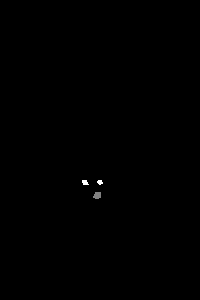

In [29]:
# TODO:  Create a function that groups geometries and draws them all on the same raster!!
# Basically do this!
xy_eye_polys = [
    [[82, 180], [83, 184], [88, 184], [86, 180]],
    [[97, 182], [99, 184], [102, 183], [101, 180], [98, 180]]
]
nose_poly = [[95, 192],
 [93, 197],
 [96, 198],
 [100, 197],
 [100, 194],
 [100, 192],
 [96, 192]
]       
# Prob provide a color mapping or something..
h,w = np_data.shape[:2]
eye_color = 255
nose_color = 128

# We are using other tools to create the masks from these points
eyes = [Polygon(points = [Point(x=x, y = y) for x,y in xy_eye_poly]) for xy_eye_poly in xy_eye_polys]
eye_masks = np.max([eye.raster(height = h, width = w, color = eye_color) for eye in eyes], axis = 0)
nose = Polygon(points = [Point(x=x, y = y) for x,y in nose_poly])
nose_mask = nose.raster(height = h, width = w, color = nose_color)
# Picks the brighter color if there is overlap. 
# If you don't want overlap then just simply create separate masks
np_seg_mask = np.max([nose_mask, eye_masks], axis = 0)
Image.fromarray(np_seg_mask)


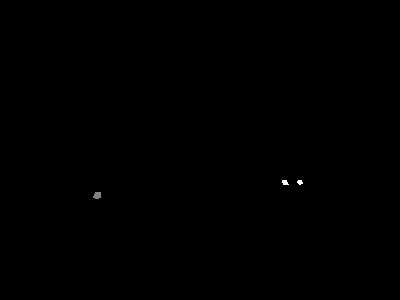

In [30]:
# Note that the signing function will not be invoked if urls are already set for these objects
# Let's make a label:

mask = RasterData(arr = np_seg_mask)

eye_annotation = ObjectAnnotation(
    name = "deer_eyes",
    value = Mask(mask = mask, color = eye_color)
)
nose_annotation =   ObjectAnnotation(
            name = "deer_nose",
            value = Mask(mask = mask, color = nose_color),
            classifications = [
                ClassificationAnnotation(
                    name = "description",
                    value = Radio(
                        answer = ClassificationAnswer(name = "wet")
                    )
                )
            ]
        )
deer_annotation = ObjectAnnotation(
            value = Polygon(points = [Point(x = x, y = y) for x,y in xy_poly]),
            name = "deer"
        )

classification = ClassificationAnnotation(name = "image_description", 
        value = Checklist(answer = [
            ClassificationAnswer(name = "bright"),
            ClassificationAnswer(name = "not_blurry"),            
        ])
)
Image.fromarray(np.hstack([nose_annotation.value.raster(), eye_annotation.value.raster()]))

In [31]:

label = Label(
    data = RasterData(arr = np_data),
    annotations = [
        deer_annotation, eye_annotation, nose_annotation, classification
    ]
)

print(label.data.url)

None


In [32]:
label.add_url_to_data(signing_function)
print(label.data.url)

https://storage.labelbox.com/ckqcx1czn06830y61gh9v02cs%2Fb2d44800-d188-299a-3e16-67f8a8c20c18-1?Expires=1627061015210&KeyName=labelbox-assets-key-3&Signature=1lvJR3Mc85VSnot-ulRVf9mgV5U


In [33]:
# We also have a mask that needs a url:
mask_annotations = [annot for annot in label.annotations if isinstance(annot.value, Mask)]
for annot in mask_annotations:
    print(annot.value.mask.url)

None
None


In [34]:
label.add_url_to_masks(signing_function)
# Note that these are the same mask but just have different colors for different classes.
# The function only uploads one url! But saves a reference to each object
for annot in mask_annotations:
    print(annot.value.mask.url)

https://storage.labelbox.com/ckqcx1czn06830y61gh9v02cs%2F4739ca27-f18c-7e26-0a0e-22e334ba96f4-1?Expires=1627061027431&KeyName=labelbox-assets-key-3&Signature=lR2gY3JmRtbfmunb7B57b_2lFPg
https://storage.labelbox.com/ckqcx1czn06830y61gh9v02cs%2F4739ca27-f18c-7e26-0a0e-22e334ba96f4-1?Expires=1627061027431&KeyName=labelbox-assets-key-3&Signature=lR2gY3JmRtbfmunb7B57b_2lFPg


### Creating Data Rows
* Our Labels objects are great for working with locally but we might want to upload to labelbox
* This is required for MAL, MEA, and to add additional labels to the data.


In [35]:
dataset = client.create_dataset(name = "label_dataset")

In [36]:
# Note that the signing function is only used if a url is not already provided
print(label.data.uid)
label.create_data_row(dataset, signing_function)
print(label.data.uid)

None
ckrf6pdl9bz9g0yao8via5piz


### Assigning Schema Ids:
* All tools, classifications, and options either have names or schema_ids.
* Locally it is convenient to provide a name so that we don't need a labelbox project to use these interfaces.
* To use MAL and MEA schema ids are required

In [37]:
# When uploading for MAL or MEA we need an ontology.
# So let's create one


from labelbox.schema.ontology import OntologyBuilder, Tool, Classification, Option
from labelbox import LabelingFrontend

# These names have to match our object names exactly!!
ontology_builder = OntologyBuilder(tools=[
    Tool(tool=Tool.Type.POLYGON, name="deer"),
    Tool(tool=Tool.Type.SEGMENTATION, name="deer_nose", 
         classifications = [
             Classification(
                 class_type = Classification.Type.RADIO, 
                 instructions = "description", 
                 options = [Option(value = "wet")]
             )]),
    Tool(tool=Tool.Type.SEGMENTATION, name="deer_eyes")    
], classifications = [
    Classification(
        Classification.Type.CHECKLIST, 
        instructions = "image_description", 
        options = [Option(value = "bright"), Option(value = "not_blurry"), Option(value = "dark")])])


editor = next(
    client.get_labeling_frontends(where=LabelingFrontend.name == "Editor"))
project = client.create_project(name="test_annotation_types")
project.setup(editor, ontology_builder.asdict())
project.datasets.connect(dataset)

ontology = OntologyBuilder.from_project(project)

In [38]:
def show_schema_ids(label):
    for annotation in label.annotations:
        print(f"Object : {annotation.name} - {annotation.schema_id}")
        for classification in annotation.classifications:
            print(f"--- Subclass : {classification.name} - {classification.schema_id}")
            option = classification.value
            print(f"--- --- Options: {option.answer.name} - {option.answer.schema_id}")

        if isinstance(annotation, ClassificationAnnotation):
            for option in annotation.value.answer:
                print(f"--- Options: {option.name} - {option.schema_id}")
show_schema_ids(label)

Object : deer - None
Object : deer_eyes - None
Object : deer_nose - None
--- Subclass : description - None
--- --- Options: wet - None
Object : image_description - None
--- Options: bright - None
--- Options: not_blurry - None


In [39]:
label.assign_schema_ids(ontology)
show_schema_ids(label)

Object : deer - ckrf6ppaebtbl0y83hcdobfz3
Object : deer_eyes - ckrf6ppaebtbp0y83gl2cbsuc
Object : deer_nose - ckrf6ppaebtbn0y83ff9g7afc
--- Subclass : description - ckrf6ppb4btbx0y83cs7dbmkh
--- --- Options: wet - ckrf6ppbobtbz0y83hw01dthf
Object : image_description - ckrf6ppadbtbj0y835jmx3qn2
--- Options: bright - ckrf6ppazbtbr0y83dt6i1elk
--- Options: not_blurry - ckrf6ppazbtbt0y83ecy918s8


### pydantic
* Labels and annotations are all pydantic models

In [10]:
# Object schema
label.schema()

# Dict representation
label.dict()

{'data': {'external_id': None,
  'uid': None,
  'im_bytes': None,
  'file_path': None,
  'url': 'asdsads',
  'arr': None},
 'annotations': [{'name': 'naem',
   'schema_id': None,
   'classifications': [],
   'extra': {},
   'value': {'extra': {},
    'points': [{'extra': {}, 'x': 0.0, 'y': 1.0},
     {'extra': {}, 'x': 1.0, 'y': 2.0},
     {'extra': {}, 'x': 3.0, 'y': 4.0}]}}],
 'extra': {}}

### Next Steps
* Annotation types should be thought of as low level interfaces
* We are working on a set of tools to make most of what is covered in this notebook happen behind the scenes
* Checkout other notebooks to see how to use higher level tools that are compatible with these interfaces

In [40]:
# Cleanup
dataset.delete()
project.delete()

In [6]:

# TODO: Make sure the error message for this isn't so bad...
# Basically if the ObjectAnnotation is missing we get a terrible union error 
# Prob add our own validators to all unions...


image_url = "asdsads"
xy_poly = [[0,1], [1,2], [3,4]]
label = Label(
    data = RasterData(url = image_url),
    annotations = [
       ObjectAnnotation(
           value =             Polygon(points = [Point(x = x, y = y) for x,y in xy_poly]),
           name = "naem"
       )
    ]
)

In [ ]:
# TODO: data.data should work with just a data_row_id!!!!!. We just need to pass in a client or something..

In [ ]:
# Create raster function on label
# Move data functions to data objects
# TODO: Create a create_from_shapely function to instantiate each geometry

In [ ]:
# TODO: Serialization function section:
#    - Show that everything is a dict
# Talk about how great pydantic is. e.g. .dict() .json() .schema()

In [8]:

# TODO: Does MAL support uploading grayscale images?
# This needs to be tested with MAL!

In [41]:
# TODO: Build ontology from annotation objects


ImportError: cannot import name 'LabelContainer' from 'labelbox.data.annotation_types.collection' (/Users/matthewsokoloff/Projects/labelbox-python/labelbox/data/annotation_types/collection.py)